<a href="https://colab.research.google.com/github/RonanBERDY/AI-Enhanced-Snake-Optimizer/blob/main/RSIandBollinger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install numpy pandas yfinance


In [3]:
import numpy as np
import pandas as pd
import yfinance as yf


In [4]:
def compute_rsi(prices, n=14):
    delta = prices.diff()

    U = np.where(delta > 0, delta, 0.0)
    D = np.where(delta < 0, -delta, 0.0)

    U = pd.Series(U, index=prices.index)
    D = pd.Series(D, index=prices.index)

    AG = U.rolling(n).mean()
    AL = D.rolling(n).mean()

    for i in range(n, len(prices)):
        AG.iloc[i] = (AG.iloc[i - 1] * (n - 1) + U.iloc[i]) / n
        AL.iloc[i] = (AL.iloc[i - 1] * (n - 1) + D.iloc[i]) / n

    RS = AG / AL
    RSI = 100 - (100 / (1 + RS))

    return RSI


In [5]:
def bollinger_bands(series, n=20, k=2):
    mb = series.rolling(n).mean()
    sigma = series.rolling(n).std(ddof=0)

    ub = mb + k * sigma
    lb = mb - k * sigma

    return mb, ub, lb


In [6]:
def standard_rsi_signals(rsi):
    signal = pd.Series(0, index=rsi.index)
    signal[rsi <= 30] = 1
    signal[rsi >= 70] = -1
    return signal


In [7]:
def bollinger_filtered_rsi_signals(rsi, n=20):
    mb, ub, lb = bollinger_bands(rsi, n=n, k=2)

    signal = pd.Series(0, index=rsi.index)

    long_condition = (rsi < lb) & (rsi.shift(1) >= lb.shift(1))
    short_condition = (rsi > ub) & (rsi.shift(1) <= ub.shift(1))

    signal[long_condition] = 1
    signal[short_condition] = -1

    return signal


In [8]:
def generate_trades(prices, signals, h):
    trades = []
    i = 0

    while i < len(signals) - h:
        if signals.iloc[i] == 1:
            ret = (prices.iloc[i + h] - prices.iloc[i]) / prices.iloc[i]
            trades.append(ret)
            i += h
        elif signals.iloc[i] == -1:
            ret = (prices.iloc[i] - prices.iloc[i + h]) / prices.iloc[i]
            trades.append(ret)
            i += h
        else:
            i += 1

    return np.array(trades)


In [9]:
def generate_trades(prices, signals, h):
    trades = []
    i = 0

    while i < len(signals) - h:
        if signals.iloc[i] == 1:
            ret = (prices.iloc[i + h] - prices.iloc[i]) / prices.iloc[i]
            trades.append(ret)
            i += h
        elif signals.iloc[i] == -1:
            ret = (prices.iloc[i] - prices.iloc[i + h]) / prices.iloc[i]
            trades.append(ret)
            i += h
        else:
            i += 1

    return np.array(trades)


In [10]:
def performance_metrics(returns):
    if len(returns) == 0:
        return None

    wins = returns[returns > 0]
    losses = returns[returns < 0]

    profit_factor = np.sum(wins) / np.sum(np.abs(losses)) if len(losses) > 0 else np.inf
    hit_ratio = len(wins) / len(returns)

    mean_r = returns.mean()
    std_r = returns.std(ddof=1)

    sharpe = mean_r / std_r if std_r != 0 else np.nan
    t_stat = sharpe * np.sqrt(len(returns))

    return {
        "Trades": len(returns),
        "Profit Factor": profit_factor,
        "Hit Ratio": hit_ratio,
        "Sharpe Ratio": sharpe,
        "T-Statistic": t_stat
    }


In [11]:
def run_backtest_ttf(start="2025-01-01"):
    # NOTE: use Yahoo ticker for Dutch TTF future continuous front month
    data = yf.download("TTF=F", start=start)
    prices = data["Close"].iloc[:, 0]

    rsi = compute_rsi(prices, n=14)

    strategies = {
        "Standard RSI": standard_rsi_signals(rsi),
        "Bollinger-Filtered RSI": bollinger_filtered_rsi_signals(rsi)
    }

    results = {}
    for strat_name, signals in strategies.items():
        results[strat_name] = {}
        for h in [5, 8, 14]:
            trades = generate_trades(prices, signals, h)
            results[strat_name][f"h={h}"] = performance_metrics(trades)
    return results

In [12]:
results = run_backtest_ttf()
for strat, horizons in results.items():
    print(f"\n=== {strat} ===")
    for h, metrics in horizons.items():
        print(h, metrics)

/tmp/ipython-input-2623937794.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("TTF=F", start=start)
[*********************100%***********************]  1 of 1 completed



=== Standard RSI ===
h=5 {'Trades': 6, 'Profit Factor': np.float64(4.036348187571001), 'Hit Ratio': 0.8333333333333334, 'Sharpe Ratio': np.float64(0.4951215505342915), 'T-Statistic': np.float64(1.21279515946465)}
h=8 {'Trades': 4, 'Profit Factor': np.float64(1.5481873138399813), 'Hit Ratio': 0.5, 'Sharpe Ratio': np.float64(0.15206125034596957), 'T-Statistic': np.float64(0.30412250069193913)}
h=14 {'Trades': 3, 'Profit Factor': np.float64(0.0), 'Hit Ratio': 0.0, 'Sharpe Ratio': np.float64(-0.9745819072563388), 'T-Statistic': np.float64(-1.6880253795053581)}

=== Bollinger-Filtered RSI ===
h=5 {'Trades': 9, 'Profit Factor': np.float64(1.7617439148940839), 'Hit Ratio': 0.5555555555555556, 'Sharpe Ratio': np.float64(0.24588012484691416), 'T-Statistic': np.float64(0.7376403745407425)}
h=8 {'Trades': 9, 'Profit Factor': np.float64(2.3765076382556827), 'Hit Ratio': 0.5555555555555556, 'Sharpe Ratio': np.float64(0.3237397472728176), 'T-Statistic': np.float64(0.9712192418184529)}
h=14 {'Trades

[*********************100%***********************]  1 of 1 completed


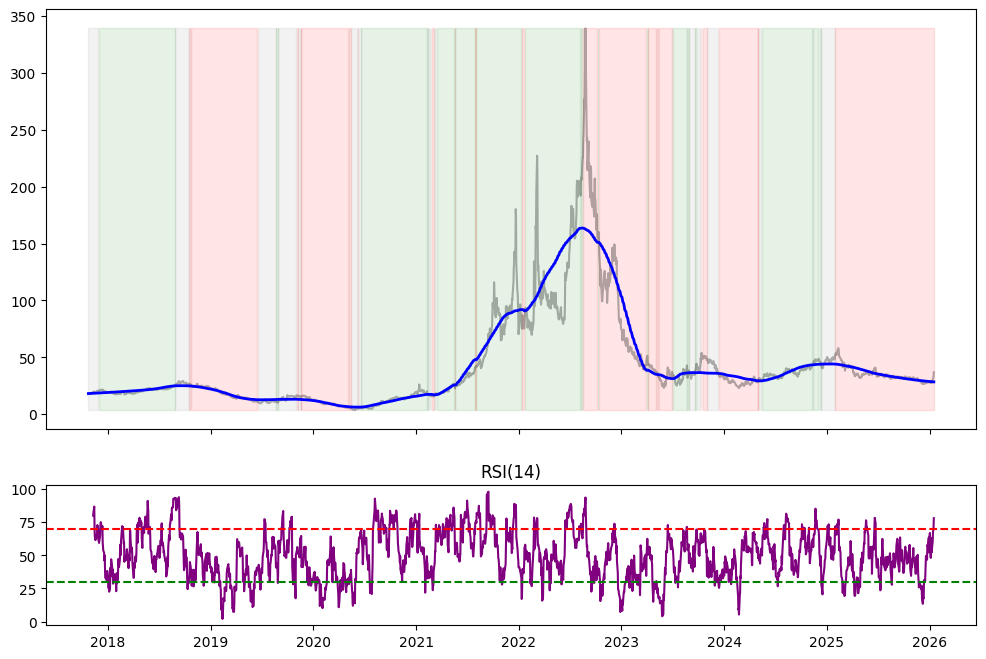

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter


ticker = "TTF=F"
data = yf.download(ticker, start="2010-01-01", end="2026-12-31", auto_adjust=True)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# 2. Lissage Macro (On prend 300 jours pour PBR pour éviter le bruit politique)
prices = data['Close'].values
data['Trend'] = savgol_filter(prices, window_length=301, polyorder=2)
data['Slope'] = np.gradient(data['Trend'])

# 3. Stratégie RSI filtrée par Cycle
# On calcule le RSI classique
delta = data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# 4. Identification des phases
def define_phase(slope):
    if slope > 0.02: return 'Bull'
    elif slope < -0.02: return 'Bear'
    else: return 'Accumulation/Distribution'

data['Cycle'] = data['Slope'].apply(define_phase)

# 5. Visualisation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(data.index, data['Close'], color='black', alpha=0.3)
ax1.plot(data.index, data['Trend'], color='blue', lw=2, label='Cycle Macro')

# Coloration des cycles
colors = {'Bull': 'green', 'Bear': 'red', 'Accumulation/Distribution': 'gray'}
for phase, color in colors.items():
    mask = data['Cycle'] == phase
    ax1.fill_between(data.index, data['Close'].min(), data['Close'].max(), where=mask, color=color, alpha=0.1)

# RSI
ax2.plot(data.index, data['RSI'], color='purple')
ax2.axhline(70, color='red', linestyle='--')
ax2.axhline(30, color='green', linestyle='--')
ax2.set_title("RSI(14)")

plt.show()

[*********************100%***********************]  1 of 1 completed


DatetimeIndex(['2026-01-15', '2026-01-16'], dtype='datetime64[ns]', name='Date', freq=None)
Date
2026-01-15    70.318805
2026-01-16    78.501315
dtype: float64


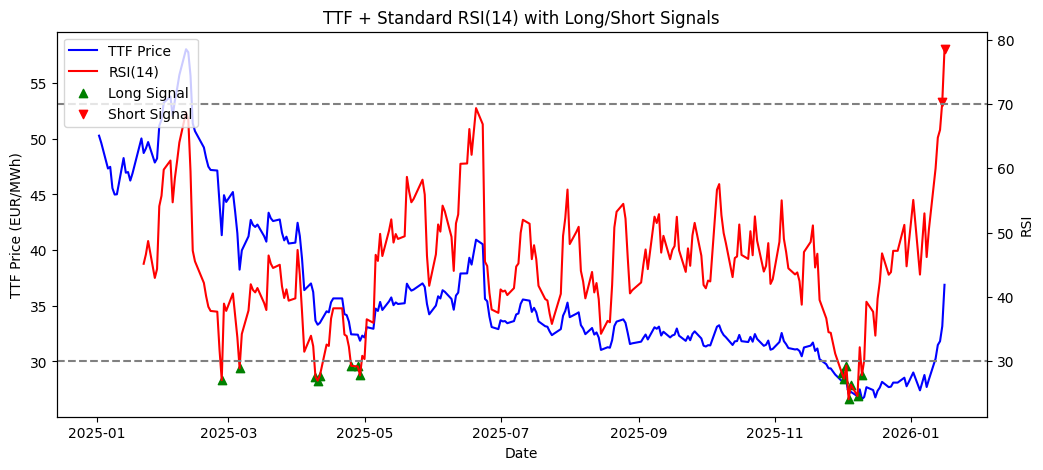

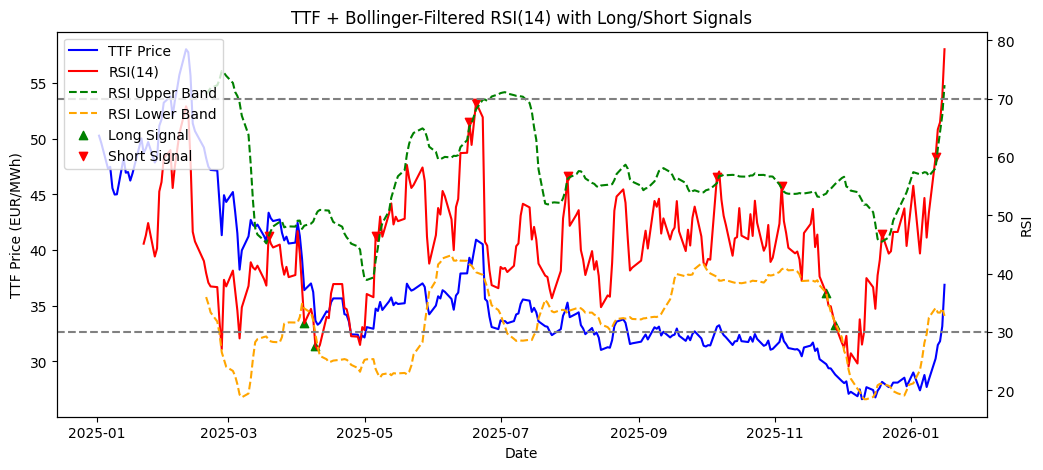

In [14]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# --- RSI (Wilder) ---
def compute_rsi(prices, n=14):
    delta = prices.diff()
    U = np.where(delta > 0, delta, 0.0)
    D = np.where(delta < 0, -delta, 0.0)

    U = pd.Series(U, index=prices.index)
    D = pd.Series(D, index=prices.index)

    AG = U.rolling(n).mean()
    AL = D.rolling(n).mean()

    for i in range(n, len(prices)):
        AG.iloc[i] = (AG.iloc[i - 1] * (n - 1) + U.iloc[i]) / n
        AL.iloc[i] = (AL.iloc[i - 1] * (n - 1) + D.iloc[i]) / n

    RS = AG / AL
    return 100 - (100 / (1 + RS))

# --- Bollinger Bands ---
def bollinger_bands(series, n=20, k=2):
    mb = series.rolling(n).mean()
    sigma = series.rolling(n).std(ddof=0)
    ub = mb + k * sigma
    lb = mb - k * sigma
    return mb, ub, lb

# --- Signal generators ---
def standard_rsi_signals(rsi, low=30, high=70):
    long_signal = (rsi <= low)
    short_signal = (rsi >= high)
    return long_signal, short_signal

def bollinger_filtered_rsi_signals(rsi, n=20, k=2):
    mb, ub, lb = bollinger_bands(rsi, n, k)
    long_signal = (rsi < lb) & (rsi.shift(1) >= lb.shift(1))
    short_signal = (rsi > ub) & (rsi.shift(1) <= ub.shift(1))
    return long_signal, short_signal, mb, ub, lb

# --- Load TTF data ---
data = yf.download("TTF=F", start="2025-01-01", auto_adjust=True) #,end="2022-01-01"
prices = data["Close"].squeeze()

# --- Compute RSI ---
rsi = compute_rsi(prices)

# --- Generate signals ---
# Standard RSI
long_std, short_std = standard_rsi_signals(rsi)

# Bollinger RSI
long_bb, short_bb, mb_rsi, ub_rsi, lb_rsi = bollinger_filtered_rsi_signals(rsi)

# --- Plot Standard RSI + TTF + signals ---
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(prices, color='blue', label='TTF Price')
ax1.set_ylabel('TTF Price (EUR/MWh)')
ax1.set_xlabel('Date')

ax2 = ax1.twinx()
ax2.plot(rsi, color='red', label='RSI(14)')
ax2.axhline(70, color='grey', linestyle='--')
ax2.axhline(30, color='grey', linestyle='--')

# Add signals
ax2.scatter(rsi.index[long_std], rsi[long_std], color='green', marker='^', label='Long Signal')
ax2.scatter(rsi.index[short_std], rsi[short_std], color='red', marker='v', label='Short Signal')
print(rsi.index[short_std])
print(rsi[short_std])
ax2.set_ylabel('RSI')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.title('TTF + Standard RSI(14) with Long/Short Signals')
plt.show()

# --- Plot Bollinger-Filtered RSI + TTF + signals ---
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(prices, color='blue', label='TTF Price')
ax1.set_ylabel('TTF Price (EUR/MWh)')
ax1.set_xlabel('Date')

ax2 = ax1.twinx()
ax2.plot(rsi, color='red', label='RSI(14)')
ax2.plot(ub_rsi, color='green', linestyle='--', label='RSI Upper Band')
ax2.plot(lb_rsi, color='orange', linestyle='--', label='RSI Lower Band')
ax2.axhline(70, color='grey', linestyle='--')
ax2.axhline(30, color='grey', linestyle='--')

# Add signals
ax2.scatter(rsi.index[long_bb], rsi[long_bb], color='green', marker='^', label='Long Signal')
ax2.scatter(rsi.index[short_bb], rsi[short_bb], color='red', marker='v', label='Short Signal')

ax2.set_ylabel('RSI')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.title('TTF + Bollinger-Filtered RSI(14) with Long/Short Signals')
plt.show()
